In [42]:
from tensorflow.keras.datasets import cifar10
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.applications.vgg19 import VGG19, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import cv2
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as BE
from tensorflow.keras.losses import categorical_crossentropy
from progressbar import ProgressBar
import os
import scipy.io
import tensorflow as tf
import json
import sys
sys.path.append('..')  
from GradPri_utils.utils import *

# from tensorflow.keras import backend as BE
# from Integrated_Gradients_algorithm import *
# from GradVisualizer import *

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.compat.v1.Session(config=config) 

# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()

In [2]:
DATA_PATH = '../datasets/ImageNetVal/'
file_name = getfile_name(DATA_PATH)
file_name = np.sort(file_name)

f = open("../datasets/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt",encoding = "utf-8")
val_ground_truth = f.read()
val_ground_truth = val_ground_truth.split('\n')
for i in range(len(val_ground_truth)-1):
    val_ground_truth[i] = int(val_ground_truth[i])

vgg19_json = json.load(open('/public/liujiawei/.keras/models/imagenet_class_index.json','r',encoding="utf-8"))

In [3]:
base_model = VGG19(weights='imagenet')

In [43]:
synsets = scipy.io.loadmat(os.path.join('../datasets', 'ILSVRC2012_devkit_t12', 'data', 'meta.mat'))['synsets']

ILSVRC2012_ID = [s[0][0][0][0] for s in synsets]

index1 = 821
WNID = [s[0][1][0] for s in synsets]
print(WNID[index1])

words = [s[0][2][0] for s in synsets]
print(words[index1])

num_train_images = [s[0][7][0][0] for s in synsets]
print(num_train_images[0])

n04263257
soup bowl
1300


In [5]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [180]:
i = 9
img_path = DATA_PATH + file_name[i]
img = image.load_img(img_path, target_size=(224, 224))
x_tmp = image.img_to_array(img)
x_tmp = np.expand_dims(x_tmp, axis=0)
x_tmp = preprocess_input(x_tmp)
pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
print(np.argmax(pre_tmp), pre_tmp[0][np.argmax(pre_tmp)])
print(get_acc(predict_label=decode_predictions(pre_tmp, top=top_set), 
               ground_truth=WNID[val_ground_truth[i]-1]))
target_label = np.argsort(-pre_tmp) 
target_label = target_label[:,1][0]
print(target_label, pre_tmp[0][target_label])
x_adv_tmp = x_tmp.copy()
label_argmax = np.argmax(pre_tmp)
target_one_hot = np.reshape(to_categorical(label_argmax, num_class),(1,-1))
print(label_argmax)
loss0 = tf.keras.backend.eval(cce(target_one_hot, pre_tmp))
print(loss0)

332 0.8655515
True
153 0.047508273
332
0.14438844


In [181]:
grads = get_loss_gradients(x_adv_tmp, base_model, target_one_hot)
x_adv_tmp1 = np.clip(x_adv_tmp - grads*100, np.min(x_tmp), np.max(x_tmp))
pre_tmp1 = base_model.predict(np.reshape(x_adv_tmp1, [-1,224,224,3]))
loss1 = tf.keras.backend.eval(cce(target_one_hot, pre_tmp1))
x_adv_tmp2 = np.clip(x_adv_tmp + grads*100, np.min(x_tmp), np.max(x_tmp))
pre_tmp2 = base_model.predict(np.reshape(x_adv_tmp2, [-1,224,224,3]))
loss2 = tf.keras.backend.eval(cce(target_one_hot, pre_tmp2))
print((loss1-loss0)/(loss0-loss2))
print(loss0,loss1,loss2)
# print(np.argmax(pre_tmp), pre_tmp[0][np.argmax(pre_tmp)])
# print(get_acc(predict_label=decode_predictions(pre_tmp, top=top_set), 
#                ground_truth=WNID[val_ground_truth[i]-1]))
# target_label = np.argsort(-pre_tmp) 
# target_label = target_label[:,1][0]
# print(target_label, pre_tmp[0][target_label])

0.8756693
0.14438844 0.12295783 0.16886184


In [157]:
cce = tf.keras.losses.CategoricalCrossentropy()

In [156]:
grads = get_gradients(x_adv_tmp, base_model, label_argmax)
# target_one_hot = np.reshape(to_categorical(58, num_class),(1,-1))
# grads = get_loss_gradients(x_adv_tmp, base_model, target_one_hot)
x_adv_tmp1 = np.clip(x_adv_tmp + grads*100, np.min(x_tmp), np.max(x_tmp))
pre_tmp1 = base_model.predict(np.reshape(x_adv_tmp1, [-1,224,224,3]))
x_adv_tmp2 = np.clip(x_adv_tmp - grads*100, np.min(x_tmp), np.max(x_tmp))
pre_tmp2 = base_model.predict(np.reshape(x_adv_tmp2, [-1,224,224,3]))
print((pre_tmp1[0][label_argmax]-pre_tmp[0][label_argmax])/(pre_tmp[0][label_argmax]-pre_tmp2[0][label_argmax]))
print(pre_tmp1[0][label_argmax],pre_tmp[0][label_argmax],pre_tmp2[0][label_argmax])
# print(np.argmax(pre_tmp), pre_tmp[0][np.argmax(pre_tmp)])
# print(get_acc(predict_label=decode_predictions(pre_tmp, top=top_set), 
#                ground_truth=WNID[val_ground_truth[i]-1]))
# target_label = np.argsort(-pre_tmp) 
# target_label = target_label[:,1][0]
# print(target_label, pre_tmp[0][target_label])

0.9962915
0.933456 0.9328155 0.9321726


In [195]:
top_set = 1 # 预测的前n个类中包含真实标签则表示预测正确
total_sample_num = 100
img_num = range(0, total_sample_num)
ground_truth_label = []  # 记录样本的真实标签
predicted_confidence = []  # 记录样本的置信度信息
Gini = []
num_class = 1000
DATA_PATH = '../datasets/ImageNetVal/'
file_name = getfile_name(DATA_PATH)
file_name = np.sort(file_name)

pbar = ProgressBar()
for i in pbar(img_num):
    img_path = DATA_PATH + file_name[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x_tmp = image.img_to_array(img)
    x_tmp = np.expand_dims(x_tmp, axis=0)
    x_tmp = preprocess_input(x_tmp)
    pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
    predicted_confidence.append(pre_tmp)
    ground_truth_label.append(WNID[val_ground_truth[i]-1])
    
    x_adv_tmp = x_tmp.copy()
    label_argmax = np.argmax(pre_tmp)
    target_one_hot = np.reshape(to_categorical(label_argmax, num_class),(1,-1))
#     loss0 = tf.keras.backend.eval(cce(target_one_hot, pre_tmp))
    
    grads = get_loss_gradients(x_adv_tmp, base_model, target_one_hot)
    x_adv_tmp1 = x_adv_tmp - grads*100
    pre_tmp1 = base_model.predict(np.reshape(x_adv_tmp1, [-1,224,224,3]))
#     loss1 = tf.keras.backend.eval(cce(target_one_hot, pre_tmp1))
    
    x_adv_tmp2 = x_adv_tmp + grads*100
    pre_tmp2 = base_model.predict(np.reshape(x_adv_tmp2, [-1,224,224,3]))
#     loss2 = tf.keras.backend.eval(cce(target_one_hot, pre_tmp2))
    Gini.append((pre_tmp1[0][label_argmax]-pre_tmp[0][label_argmax])/(pre_tmp[0][label_argmax]-pre_tmp2[0][label_argmax]))

/public/liujiawei/anaconda3/envs/ZHB_env/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in float_scalars
/public/liujiawei/anaconda3/envs/ZHB_env/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in float_scalars
100% |########################################################################|


In [196]:
indexs = np.argsort(Gini)
indexs = indexs[::-1]
# 计算APFD指标
APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                    predicted_confidence=np.array(predicted_confidence), top_set=top_set,
                   decode_predictions=decode_predictions)
print("APFD: ", APFD)

# 计算RAUC指标
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                    predicted_confidence=np.array(predicted_confidence), top_set=top_set,
                    decode_predictions=decode_predictions)
print("RAUC: ", RAUC)

100% |########################################################################|


APFD:  0.5544285714285714
RAUC:  0.6619621342512909


In [14]:
top_set = 1 # 预测的前n个类中包含真实标签则表示预测正确
total_sample_num = 3000
img_num = range(0, total_sample_num)
ground_truth_label = []  # 记录样本的真实标签
predicted_confidence = []  # 记录样本的置信度信息
num_class = 1000
DATA_PATH = '../datasets/ImageNetVal/'
file_name = getfile_name(DATA_PATH)
file_name = np.sort(file_name)

X_adv = []  # 保存对抗样本
X_org = []  # 保存对抗样本对应的原始样本
ground_truth_label = []  # 记录样本的真实标签
predicted_confidence = []  # 记录原始样本的置信度信息
X_adv_predicted_confidence = []  # 记录对抗样本的置信度信息
index1 = [] # 记录被攻击成功的样本的位置
max_iter = 1
eps_pertur = 5e+5
max_mean_pertur = 10
conf_thre = 0.8 # 对抗样本的置信度阈值

pbar = ProgressBar()
for i in pbar(img_num):
    img_path = DATA_PATH + file_name[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x_tmp = image.img_to_array(img)
    x_tmp = np.expand_dims(x_tmp, axis=0)
    x_tmp = preprocess_input(x_tmp)
    pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
    
    if get_acc(predict_label=decode_predictions(pre_tmp, top=top_set), 
               ground_truth=WNID[val_ground_truth[i]-1]): # 选取能够被正确分类的样本
        target_one_hot = np.reshape(to_categorical(np.argmax(pre_tmp), num_class),(1,-1))
        x_adv_tmp = x_tmp.copy()
        
        target_label = np.argsort(-pre_tmp) 
        target_label = target_label[:,1][0]  # 置信度第二高的标签，作为目标标签
#         grads = BE.gradients(loss = base_model.layers[-1].output[:,target_label], variables = base_model.inputs)
#         get_gradients = BE.function(inputs=base_model.inputs[0], outputs=grads)
#         pbar = ProgressBar()
        for ii in range(0, max_iter):
            grads = get_gradients(x_adv_tmp, base_model, target_label)
            x_adv_tmp = np.clip(x_adv_tmp + grads*eps_pertur, np.min(x_tmp), np.max(x_tmp))
            
            if np.mean(np.abs(x_adv_tmp-x_tmp)) > max_mean_pertur:  # 如果扰动大于平均对抗扰动，则跳出迭代
                break
                
            x_adv_pre_tmp = base_model.predict(np.reshape(x_adv_tmp, [-1,224,224,3]))
            if not get_acc(predict_label=decode_predictions(x_adv_pre_tmp, top=top_set), 
                            ground_truth=WNID[val_ground_truth[i]-1]):  # 如果攻击成功，则判断置信度
                if np.max(x_adv_pre_tmp) > conf_thre : # 当置信度大于阈值，保存该样本
#                     print('attack succeed!')
                    X_adv.append(x_adv_tmp)
                    X_org.append(x_tmp)
                    ground_truth_label.append(WNID[val_ground_truth[i]-1])
                    X_adv_predicted_confidence.append(x_adv_pre_tmp)
                    predicted_confidence.append(pre_tmp)
                    index1.append(i)
                    break

100% |########################################################################|


In [15]:
np.shape(index1)

(556,)

In [16]:
np.save('./featureExtraction/ImageNet_'+str(len(index1))+'samples_OneStepAdvOrg.npy',{
    'X_adv': np.array(X_adv),
    'X_org': np.array(X_org),
    'ground_truth_label': np.array(ground_truth_label),
    'X_adv_predicted_confidence': np.array(X_adv_predicted_confidence),
    'predicted_confidence': np.array(predicted_confidence),
    'index1': np.array(index1),
}) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


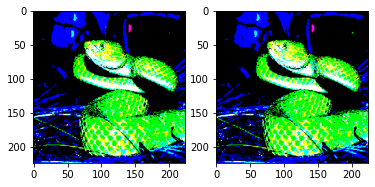

In [18]:
plt.figure()
pos1 = 3
plt.subplot(121)
plt.imshow(X_adv[pos1].reshape((224, 224, 3)))
plt.subplot(122)
plt.imshow(X_org[pos1].reshape((224, 224, 3)))

In [19]:
np.mean(np.abs(X_adv[pos1]-X_org[pos1]))

2.0211413